In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from seq_draw import *

In [3]:
class Span(object):
    def __init__(self, seq_diagram, xstart, xspan, yoff, label=None, arrow_kw={}):
        self.sq = seq_diagram
        self.xstart = xstart
        self.xstop = xstart + xspan
        self.xspan = xspan
        self.xcenter = xstart + xspan / 2
        self.yoff = yoff
        self.label = label
        self.font_kw = {}
        self.font_kw['bbox'] = dict(facecolor='white', alpha=1.0, edgecolor='white')
        self.font_kw['verticalalignment'] = 'center'
        self.font_kw['horizontalalignment'] = 'center'
        self.font_kw['size'] = 'large'
        self.arrow_kw = {'length_includes_head': True,
                         'head_width': 0.05,
                         'head_length': 0.075,
                         'color': 'black'}
#         self._update_arrow_kw(arrow_kw)
        pass

    def _update_arrow_kw(self, new_kw):
        for key in new_kw.keys():
            self.arrow_kw[key] = new_kw[key]
        pass

    def _draw(self):
        self.sq.ax.arrow(self.xstart, self.yoff, self. xstop - self.xstart, 0, label=self.label, **self.arrow_kw)
        self.sq.ax.arrow(self.xstop, self.yoff, self.xstart - self.xstop, 0, label=self.label, **self.arrow_kw)
        self.sq.ax.text(self.xcenter, self.yoff, self.label, **self.font_kw)

(0.0, 1.0)

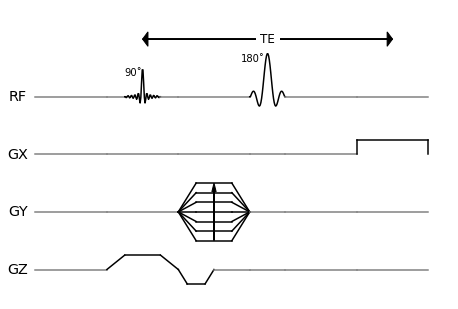

In [4]:
# init sequence diagram
sd = SeqDiagram()

# inti with useful start values
sd.init_axes()

# define pulses
exc_pulse = SincPulse(sd, 'rf', .5, 0.1, label=u'90˚', side_lobes=10)
ref_pulse = SincPulse(sd, 'rf', .5, 0.15, label=u'180˚', label_coord=(-0.125, 0.15))
hs = HyperbolicSecantPulse(sd, 'rf', 0.5, 0.1, beta=3)
gauss = GaussPulse(sd, 'rf', 0.5, 0.1, beta=3)

# gradients
rect_grad = gradients.RectGrad(sd, 'gz', 1.0, 0.1)
read_grad = gradients.RectGrad(sd, 'gx', 1.0, 0.05)
slisel = gradients.TrapGrad(sd, 'gx', 1.0, 0.05, ft_ramp_ratio=1.0)
slisel_rephase = gradients.TrapGrad(sd, 'gx', .5, -0.05, ft_ramp_ratio=1.0)
phase_enc = gradients.TrapGradTable(sd, 'gy', 1.0, 0.1, -0.1, tab_type=gradients.GradTableType.ASCENDING)

# define draw style
plot_kw = plot_kw={'linestyle': '-', 'color': 'gray'}

# define some time increments
delta = Line(sd, 'rf',1.0, plot_kw=plot_kw)
delta_half = Line(sd, 'rf',.5, plot_kw=plot_kw)
delta_quart = Line(sd, 'rf',.25, plot_kw=plot_kw)

# Add pulses to axes
sd.add_atom(sd.set_axis([[delta, delta_quart], exc_pulse, delta_quart, delta, ref_pulse, delta, delta], 'rf'))
sd.add_atom(sd.set_axis([delta, delta, delta, delta_half, delta, read_grad], 'gx'))
sd.add_atom(sd.set_axis([delta, delta, phase_enc, delta_half, delta, delta], 'gy'))
sd.add_atom(sd.set_axis([delta, slisel, slisel_rephase, delta_half, delta_half, delta, delta], 'gz'))

# add echo time arrow
tmp = sd.get_total_duration([exc_pulse, delta_half, delta, ref_pulse, delta])
te_span = Span(sd, 0.5 + delta.duration + exc_pulse.duration/2 + delta_quart.duration, tmp, .9, 'TE')
te_span._draw()

sd.draw()
sd.ax.set_ylim(0., 1.)
# sd.ax.set_xlim(5., 6.)


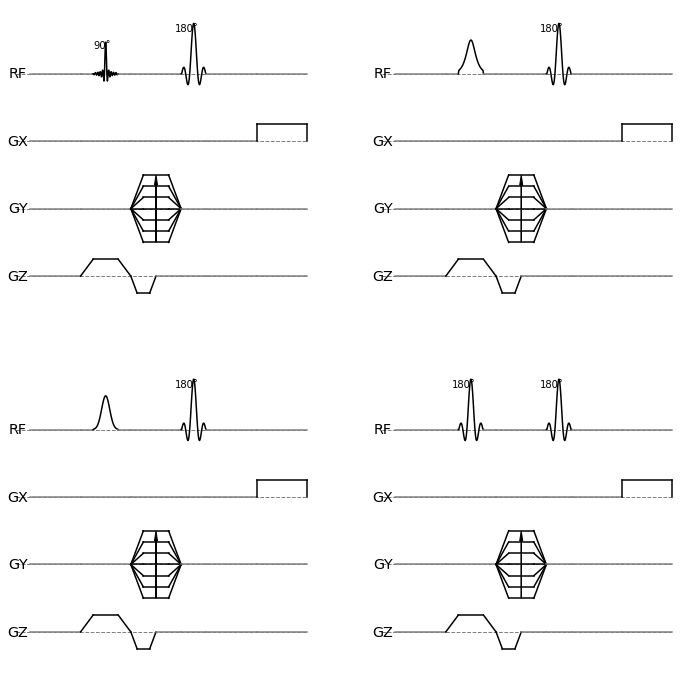

In [6]:
rf_pulses = [exc_pulse, hs, gauss, ref_pulse]
fig = plt.figure(figsize=(12,12))
for i in range(4):
    # create axes and remove ticks, etc
    ax = plt.subplot(2,2,i+1, frameon=False)
    # change excitation pulses
    sd.sqaxes['rf']['atoms'][3] = rf_pulses[i]
    sd.ax = ax
    ax.axes.axhline(0.7, 0., 0.95, color='gray', linestyle='dashed', linewidth=1.)
    ax.axes.axhline(0.5, 0., 0.95, color='gray', linestyle='dashed', linewidth=1.)
    ax.axes.axhline(0.3, 0., 0.95, color='gray', linestyle='dashed', linewidth=1.)
    ax.axes.axhline(0.1, 0., 0.95, color='gray', linestyle='dashed', linewidth=1.)
    sd.draw()
    


In [ ]:
sd.ax.axes.transAxes.pass_through?